# Using pre-trained convnets
We can use the convolutional bases of models pre-trained on the ImageNet databases. Using part of or all of the convolutional base of another model is practicing **feature extraction**. We can later use **fine-tuning** to further improve the model.

In [1]:
from keras.applications import VGG16

conv_base = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(150, 150, 3))

conv_base.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

This is the pre-trained convolutional base from a **VGG16** architecture model. This convolutional base learns abstract spatial patterns in the input data. Now, we want to classify whether the output is a **cat or dog**, so we can add a densely-connected classifier at the end. 

We have two options: process the output of the convolutional base independently in a classifier, or connect the classifier to the convolutional base. The first option will not allow us to use **data augmentation** because an input image will only be run through the model once, but we have less computations. The second option allows us to use **data augmentation**, but will be more expensive since an image will be run through the base every time the model receives it as input.

# Fast image classification

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [3]:
os.listdir('../data')

['dogs-and-cats-small', '.DS_Store', 'kaggle-dogs-cats-data']

In [4]:
os.listdir('../data/dogs-and-cats-small')

['.DS_Store', 'test', 'train', 'validation']

In [5]:
base_dir = '../data/dogs-and-cats-small'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

We'll make a function here that will extract the feature map from the trained convolutional base above. The feature map will be put in a numpy array to be plugged into a classifier

In [6]:
def extract_features(directory, sample_count):
    # (4, 4, 512) because that's the output shape of the conv. base above
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        # Target size is (150, 150) just like our convnet trained from scratch before
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        # Generates feature maps for first batch of 20 images from the directory parameter
        features_batch = conv_base.predict(inputs_batch)
        # Place the predicted feature maps and labels for the batch into the corresponding numpy arrays, in 20 spaces
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        
        i += 1
        # If we've seen all images once, then break
        # 'i' is incremented by one each loop and each loop has a batch size of 20 images, as set before,
        # so if 'i * 20' is greater than the desired sample size of images, we exit the loop
        if i * batch_size >= sample_count:
            break
            
    # Returns the numpy arrays of feature maps and corresponding labels
    return features, labels

In [7]:
"""The features are all of shape (sample_count, 4, 4, 512) because they came
straight from the conv. base's prediction. The densely connected classifier only uses
flattened data, so we can flatten the data before putting them in a classifier
"""
train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# Here, we flatten the numpy arrays for densely-connected classification
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
valid_features = np.reshape(valid_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [25]:
# Now we create the densly connected classifier
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [26]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(valid_features, valid_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6006 - acc: 0.6825 - val_loss: 0.4346 - val_acc: 0.8350
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4223 - acc: 0.8090 - val_loss: 0.3790 - val_acc: 0.8370
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3610 - acc: 0.8445 - val_loss: 0.3226 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3132 - acc: 0.8700 - val_loss: 0.2999 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2949 - acc: 0.8745 - val_loss: 0.2836 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2559 - acc: 0.8985 - val_loss: 0.2780 - val_acc: 0.8870
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2507 - acc: 0.8985 - val_loss: 0.2946 - val_acc: 0.8710
Epoch 8/30
200

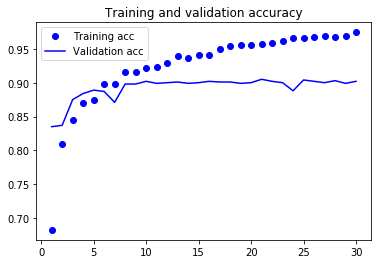

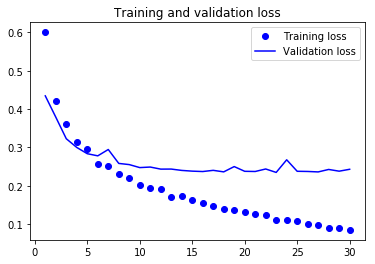

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation loss is not decreasing, our network is just remembering the data exactly as we input it, and not the patterns in the data. We need to use **data augmentation** since we have a small dataset. This will take much more time, but we should get better results.